In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Определение класса CustomDataset для загрузки изображений и меток
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Загрузка и предварительная обработка данных
def load_images_from_folder(folder):
    image_paths = []
    labels = []
    class_names = os.listdir(folder)
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(class_name)
    return image_paths, labels

# Загрузка изображений
folder_path = 'C:/Users/asus/Desktop/DS AITU/FinalProject/Agricultural-crops'  # Укажите путь к вашей папке с данными
image_paths, labels = load_images_from_folder(folder_path)

# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Преобразования для изображений
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Создание объектов DataLoader для PyTorch
train_dataset = CustomDataset(X_train, y_train, transform=transform_train)
test_dataset = CustomDataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

# Определение архитектуры модели
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(256)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(512)
        )

        # Используем примерный тензор для подсчета размера выходных данных после всех сверточных и пуллинговых слоев
        self._initialize_fc(num_classes)

    def _initialize_fc(self, num_classes):
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, 128, 128)
            out = self.layer1(sample_input)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = out.view(out.size(0), -1)
            n_size = out.size(1)

        self.fc1 = nn.Linear(n_size, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Параметры модели
num_classes = len(np.unique(labels))

# Инициализация модели
model = CNNModel(num_classes).to(device)
print(f'Model is on {next(model.parameters()).device}')

# Инициализация весов с помощью метода Xavier
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Функция для тестирования модели
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Обучение модели
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

# Тестирование модели
test_model(model, test_loader)


Using device: cuda
Training set: 663 samples
Test set: 166 samples
Model is on cuda:0
Epoch [1/50], Loss: 29.7903
Epoch [2/50], Loss: 33.0232
Epoch [3/50], Loss: 27.8310
Epoch [4/50], Loss: 28.9491
Epoch [5/50], Loss: 22.7447
Epoch [6/50], Loss: 20.0833
Epoch [7/50], Loss: 21.1742
Epoch [8/50], Loss: 18.4377
Epoch [9/50], Loss: 14.7825
Epoch [10/50], Loss: 12.9825
Epoch [11/50], Loss: 8.7663
Epoch [12/50], Loss: 5.5318
Epoch [13/50], Loss: 4.6910
Epoch [14/50], Loss: 3.2969
Epoch [15/50], Loss: 3.5886
Epoch [16/50], Loss: 2.5142
Epoch [17/50], Loss: 2.2418
Epoch [18/50], Loss: 2.0149
Epoch [19/50], Loss: 1.9518
Epoch [20/50], Loss: 1.3626
Epoch [21/50], Loss: 1.4168
Epoch [22/50], Loss: 1.5398
Epoch [23/50], Loss: 1.6414
Epoch [24/50], Loss: 1.3440
Epoch [25/50], Loss: 1.4258
Epoch [26/50], Loss: 1.0906
Epoch [27/50], Loss: 1.4229
Epoch [28/50], Loss: 0.9775
Epoch [29/50], Loss: 1.0406
Epoch [30/50], Loss: 0.8915
Epoch [31/50], Loss: 1.1004
Epoch [32/50], Loss: 1.0390
Epoch [33/50], Lo

Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.62      0.56      0.59         9
       Coffee-plant       0.43      0.43      0.43         7
           Cucumber       0.00      0.00      0.00         7
   Fox_nut(Makhana)       0.75      0.75      0.75         4
              Lemon       0.50      0.50      0.50         4
         Olive-tree       0.50      0.67      0.57         3
Pearl_millet(bajra)       0.78      0.58      0.67        12
      Tobacco-plant       0.17      0.20      0.18         5
             almond       0.20      0.25      0.22         4
             banana       0.00      0.00      0.00         7
           cardamom       0.67      0.33      0.44         6
             chilli       0.40      0.50      0.44         4
              clove       0.00      0.00      0.00         3
            coconut       1.00      0.50      0.67         2
             cotton       1.00      0.60      0.75         5


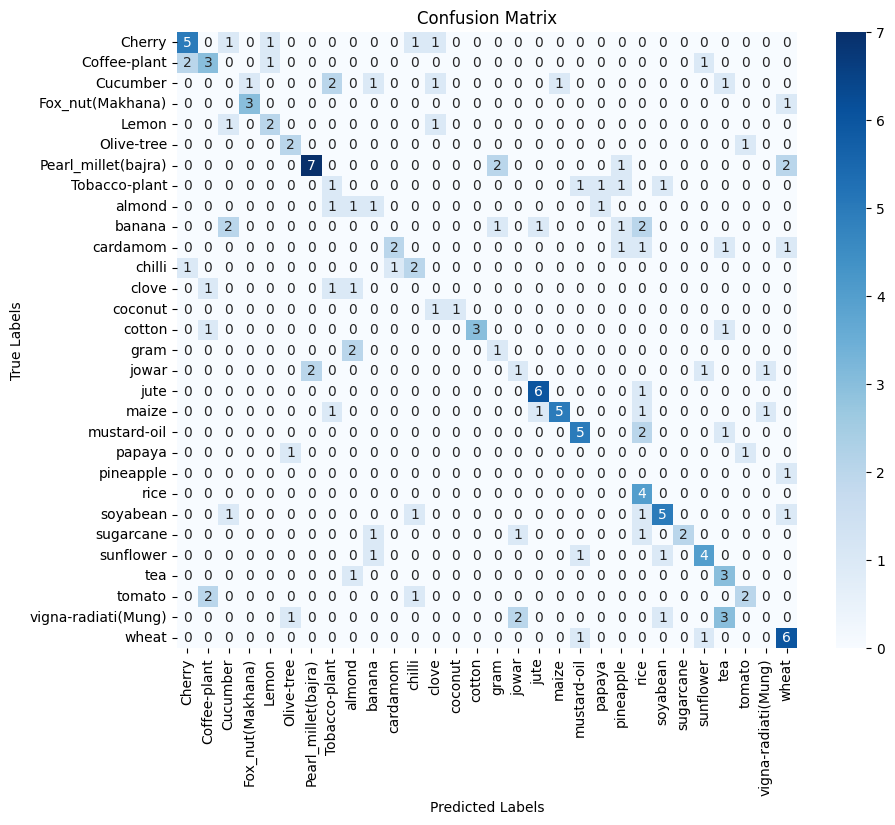

Overall Accuracy: 45.78%


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Модифицированная функция для тестирования модели с использованием дополнительных метрик
def test_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Генерация классификационного отчета
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Построение матрицы неточностей
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Вычисление общей точности
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Вызов функции тестирования с метриками
test_model_with_metrics(model, test_loader, class_names=label_encoder.classes_)


<h2>ResNet50(Pretrained)<h2>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Определение класса CustomDataset для загрузки изображений и меток
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Загрузка и предварительная обработка данных
def load_images_from_folder(folder):
    image_paths = []
    labels = []
    class_names = os.listdir(folder)
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(class_name)
    return image_paths, labels

# Загрузка изображений
folder_path = 'C:/Users/asus/Desktop/DS AITU/FinalProject/Agricultural-crops'  # Укажите путь к вашей папке с данными
image_paths, labels = load_images_from_folder(folder_path)

# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Преобразования для изображений
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Создание объектов DataLoader для PyTorch
train_dataset = CustomDataset(X_train, y_train, transform=transform_train)
test_dataset = CustomDataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

# Использование предобученной модели ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(np.unique(labels)))
)
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Функция для обучения модели с техникой Early Stopping
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        scheduler.step(epoch_loss)
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Функция для тестирования модели
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Обучение модели
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=100)

# Загрузка лучшей модели и тестирование
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)


Using device: cuda
Training set: 663 samples
Test set: 166 samples
Epoch [1/100], Loss: 3.0689
Epoch [2/100], Loss: 2.0732
Epoch [3/100], Loss: 1.5802
Epoch [4/100], Loss: 1.2912
Epoch [5/100], Loss: 1.0800
Epoch [6/100], Loss: 0.9898
Epoch [7/100], Loss: 0.7630
Epoch [8/100], Loss: 0.7024
Epoch [9/100], Loss: 0.6803
Epoch [10/100], Loss: 0.4692
Epoch [11/100], Loss: 0.4817
Epoch [12/100], Loss: 0.4209
Epoch [13/100], Loss: 0.3835
Epoch [14/100], Loss: 0.3341
Epoch [15/100], Loss: 0.2691
Epoch [16/100], Loss: 0.3229
Epoch [17/100], Loss: 0.3423
Epoch [18/100], Loss: 0.3318
Epoch [19/100], Loss: 0.2423
Epoch [20/100], Loss: 0.2218
Epoch [21/100], Loss: 0.2637
Epoch [22/100], Loss: 0.3036
Epoch [23/100], Loss: 0.2292
Epoch [24/100], Loss: 0.2308
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Epoch [25/100], Loss: 0.1719
Epoch [26/100], Loss: 0.1014
Epoch [27/100], Loss: 0.0625
Epoch [28/100], Loss: 0.0474
Epoch [29/100], Loss: 0.0468
Epoch [30/100], Loss: 0.0378
Epoch [31/

Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.60      0.67      0.63         9
       Coffee-plant       0.83      0.71      0.77         7
           Cucumber       1.00      0.86      0.92         7
   Fox_nut(Makhana)       0.80      1.00      0.89         4
              Lemon       0.44      1.00      0.62         4
         Olive-tree       0.67      0.67      0.67         3
Pearl_millet(bajra)       0.83      0.83      0.83        12
      Tobacco-plant       0.80      0.80      0.80         5
             almond       1.00      0.75      0.86         4
             banana       1.00      0.86      0.92         7
           cardamom       1.00      0.67      0.80         6
             chilli       1.00      0.75      0.86         4
              clove       0.67      0.67      0.67         3
            coconut       0.50      1.00      0.67         2
             cotton       1.00      0.80      0.89         5


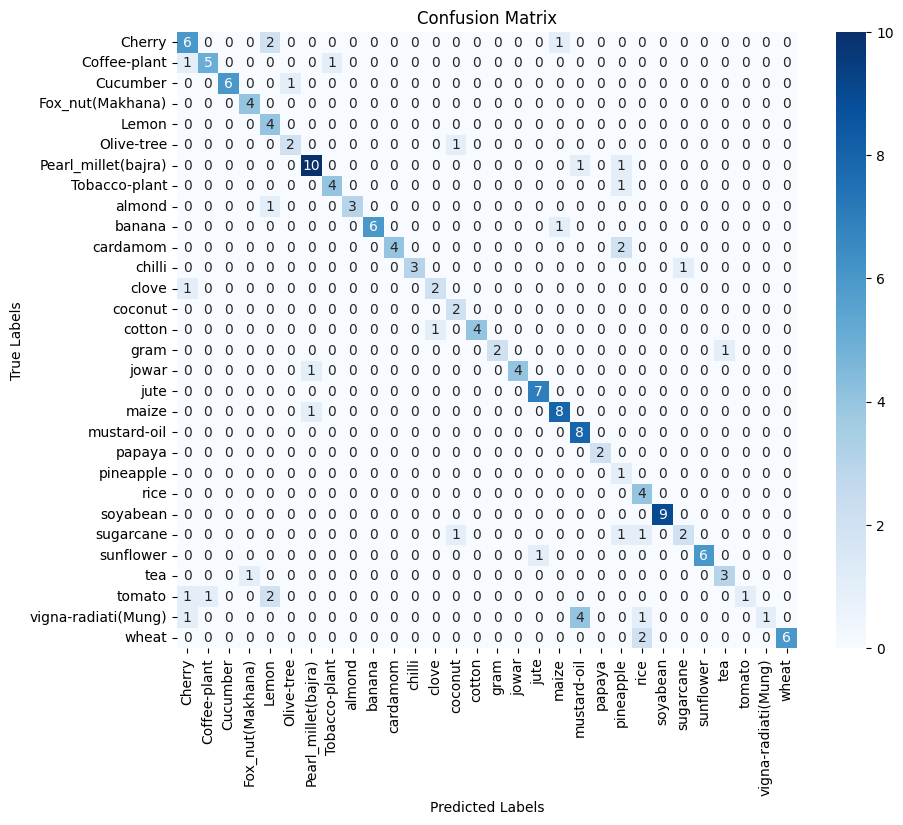

Overall Accuracy: 77.71%


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Модифицированная функция для тестирования модели с использованием дополнительных метрик
def test_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Генерация классификационного отчета
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Построение матрицы неточностей
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Вычисление общей точности
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Вызов функции тестирования с метриками
test_model_with_metrics(model, test_loader, class_names=label_encoder.classes_)


<h2>ResNet18(Pretrained)<h2>

Using device: cuda
Training set: 663 samples
Test set: 166 samples


c:\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 3.4488
Epoch [2/50], Loss: 3.0384
Epoch [3/50], Loss: 2.6172
Epoch [4/50], Loss: 2.2183
Epoch [5/50], Loss: 1.8858
Epoch [6/50], Loss: 1.6099
Epoch [7/50], Loss: 1.3702
Epoch [8/50], Loss: 1.1514
Epoch [9/50], Loss: 1.0425
Epoch [10/50], Loss: 0.8877
Epoch [11/50], Loss: 0.8041
Epoch [12/50], Loss: 0.8061
Epoch [13/50], Loss: 0.8034
Epoch [14/50], Loss: 0.7868
Epoch [15/50], Loss: 0.7515
Epoch [16/50], Loss: 0.7519
Epoch [17/50], Loss: 0.7306
Epoch [18/50], Loss: 0.7496
Epoch [19/50], Loss: 0.7198
Epoch [20/50], Loss: 0.7126
Epoch [21/50], Loss: 0.7010
Epoch [22/50], Loss: 0.7177
Epoch [23/50], Loss: 0.7088
Epoch [24/50], Loss: 0.7005
Epoch [25/50], Loss: 0.6867
Epoch [26/50], Loss: 0.7245
Epoch [27/50], Loss: 0.7087
Epoch [28/50], Loss: 0.7043
Epoch [29/50], Loss: 0.7169
Epoch [30/50], Loss: 0.6944
Early stopping triggered
Test Accuracy: 74.10%


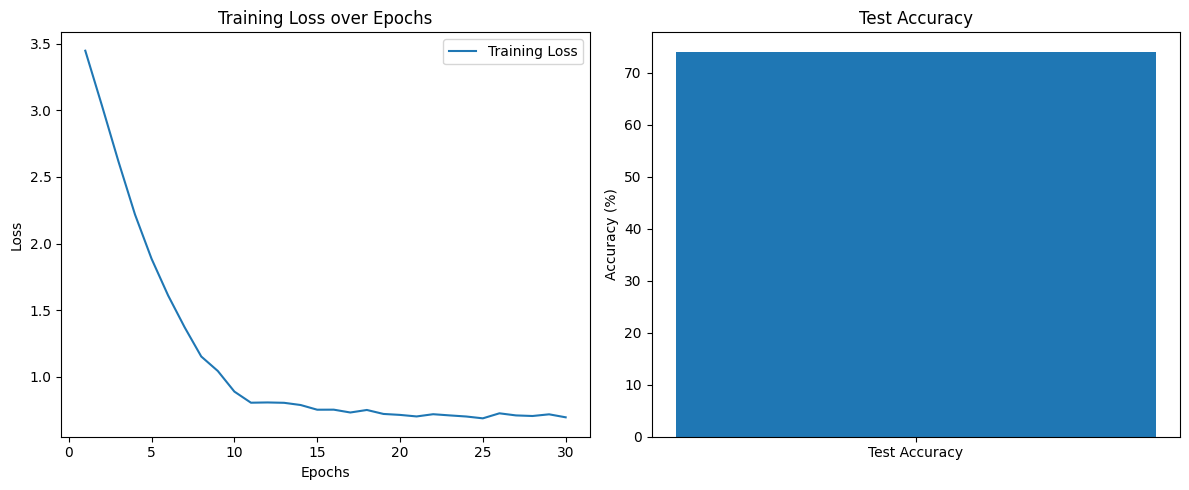

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Определение класса CustomDataset для загрузки изображений и меток
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Загрузка и предварительная обработка данных
def load_images_from_folder(folder):
    image_paths = []
    labels = []
    class_names = os.listdir(folder)
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(class_name)
    return image_paths, labels

# Загрузка изображений
folder_path = 'C:/Users/asus/Desktop/DS AITU/FinalProject/Agricultural-crops'  # Укажите путь к вашей папке с данными
image_paths, labels = load_images_from_folder(folder_path)

# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Преобразования для изображений
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Создание объектов DataLoader для PyTorch
train_dataset = CustomDataset(X_train, y_train, transform=transform_train)
test_dataset = CustomDataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

# Использование предобученной модели ResNet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(np.unique(labels)))
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Функция для обучения модели с техникой Early Stopping
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return loss_history

# Функция для тестирования модели
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Функция для отображения результатов обучения
def plot_training_results(loss_history, test_accuracy):
    epochs = range(1, len(loss_history) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plotting the training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    
    # Display the test accuracy
    plt.subplot(1, 2, 2)
    plt.bar(['Test Accuracy'], [test_accuracy])
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    
    plt.tight_layout()
    plt.show()

# Обучение модели и сбор истории потерь
loss_history = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

# Загрузка лучшей модели и тестирование
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = test_model(model, test_loader)

# Отображение результатов
plot_training_results(loss_history, test_accuracy)


Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.75      0.67      0.71         9
       Coffee-plant       0.60      0.43      0.50         7
           Cucumber       0.86      0.86      0.86         7
   Fox_nut(Makhana)       0.80      1.00      0.89         4
              Lemon       0.67      1.00      0.80         4
         Olive-tree       1.00      0.67      0.80         3
Pearl_millet(bajra)       0.71      0.83      0.77        12
      Tobacco-plant       0.67      0.80      0.73         5
             almond       1.00      0.50      0.67         4
             banana       0.80      0.57      0.67         7
           cardamom       1.00      0.67      0.80         6
             chilli       0.80      1.00      0.89         4
              clove       0.67      0.67      0.67         3
            coconut       0.67      1.00      0.80         2
             cotton       0.75      0.60      0.67         5


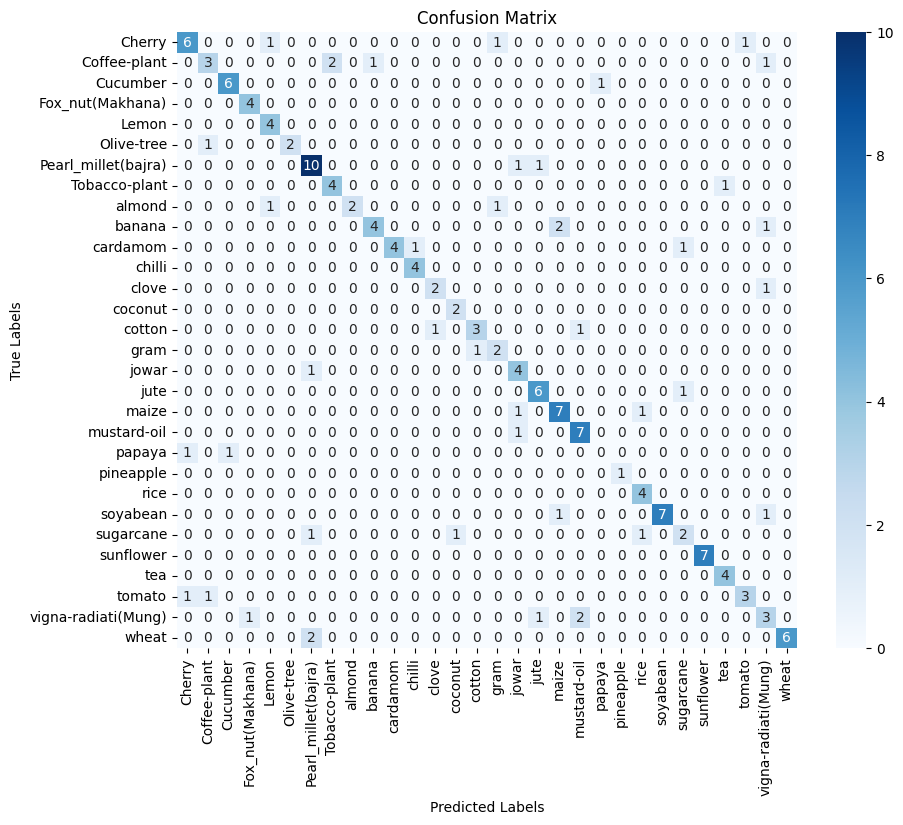

Overall Accuracy: 74.10%


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Модифицированная функция для тестирования модели с использованием дополнительных метрик
def test_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Генерация классификационного отчета
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Построение матрицы неточностей
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Вычисление общей точности
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Вызов функции тестирования с метриками
test_model_with_metrics(model, test_loader, class_names=label_encoder.classes_)


<h2>EfficientNet(Pretrained)<h2>

Using device: cuda
Training set: 663 samples
Test set: 166 samples
Epoch [1/100], Loss: 3.0067
Epoch [2/100], Loss: 1.8381
Epoch [3/100], Loss: 1.1657
Epoch [4/100], Loss: 0.8946
Epoch [5/100], Loss: 0.6592
Epoch [6/100], Loss: 0.5545
Epoch [7/100], Loss: 0.5294
Epoch [8/100], Loss: 0.4507
Epoch [9/100], Loss: 0.3631
Epoch [10/100], Loss: 0.4110
Epoch [11/100], Loss: 0.3559
Epoch [12/100], Loss: 0.3399
Epoch [13/100], Loss: 0.2930
Epoch [14/100], Loss: 0.3244
Epoch [15/100], Loss: 0.3232
Epoch [16/100], Loss: 0.2668
Epoch [17/100], Loss: 0.2833
Epoch [18/100], Loss: 0.1964
Epoch [19/100], Loss: 0.1880
Epoch [20/100], Loss: 0.1895
Epoch [21/100], Loss: 0.2323
Epoch [22/100], Loss: 0.2033
Epoch [23/100], Loss: 0.2256
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Epoch [24/100], Loss: 0.1461
Epoch [25/100], Loss: 0.1221
Epoch [26/100], Loss: 0.0973
Epoch [27/100], Loss: 0.0737
Epoch [28/100], Loss: 0.0730
Epoch [29/100], Loss: 0.0686
Epoch [30/100], Loss: 0.0518
Epoch [31/

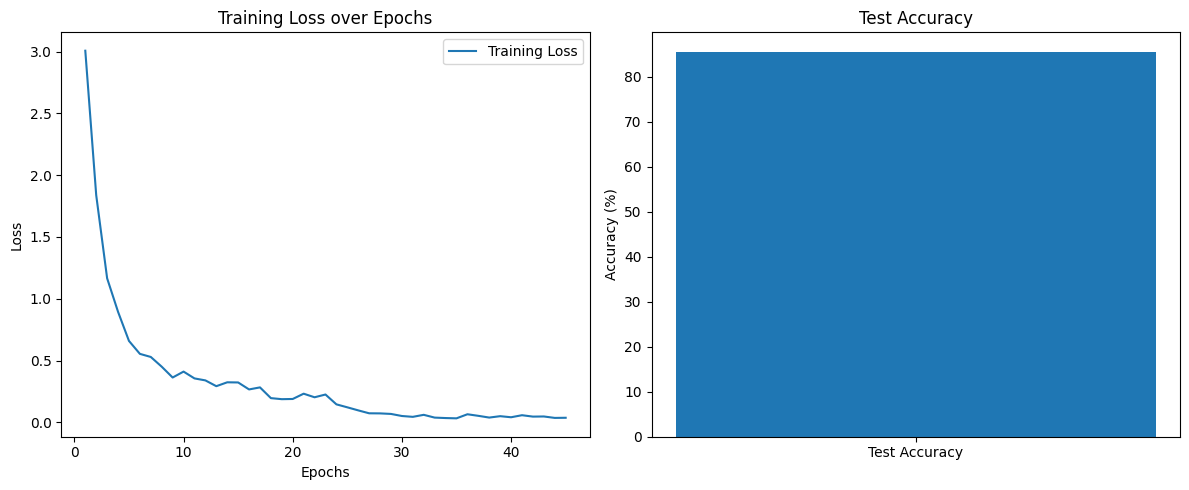

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Определение класса CustomDataset для загрузки изображений и меток
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = np.array(image)
            image = self.transform(image=image)["image"]
        label = self.labels[idx]
        return image, label

# Загрузка и предварительная обработка данных
def load_images_from_folder(folder):
    image_paths = []
    labels = []
    class_names = os.listdir(folder)
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(class_name)
    return image_paths, labels

# Загрузка изображений
folder_path = 'C:/Users/asus/Desktop/DS AITU/FinalProject/Agricultural-crops'  # Укажите путь к вашей папке с данными
image_paths, labels = load_images_from_folder(folder_path)

# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Преобразования для изображений с использованием Albumentations
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.RGBShift(p=0.2),
    A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
    A.ToGray(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

transform_test = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Создание объектов DataLoader для PyTorch
train_dataset = CustomDataset(X_train, y_train, transform=transform_train)
test_dataset = CustomDataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

# Использование предобученной модели EfficientNet
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(np.unique(labels)))
)
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Функция для обучения модели с техникой Early Stopping
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        scheduler.step(epoch_loss)
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return loss_history

# Функция для тестирования модели
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Функция для отображения результатов обучения
def plot_training_results(loss_history, test_accuracy):
    epochs = range(1, len(loss_history) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plotting the training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    
    # Display the test accuracy
    plt.subplot(1, 2, 2)
    plt.bar(['Test Accuracy'], [test_accuracy])
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    
    plt.tight_layout()
    plt.show()

# Обучение модели и сбор истории потерь
loss_history = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=100)

# Загрузка лучшей модели и тестирование
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = test_model(model, test_loader)

# Отображение результатов
plot_training_results(loss_history, test_accuracy)


Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.88      0.78      0.82         9
       Coffee-plant       1.00      0.71      0.83         7
           Cucumber       1.00      1.00      1.00         7
   Fox_nut(Makhana)       1.00      0.75      0.86         4
              Lemon       0.57      1.00      0.73         4
         Olive-tree       1.00      1.00      1.00         3
Pearl_millet(bajra)       0.92      0.92      0.92        12
      Tobacco-plant       0.71      1.00      0.83         5
             almond       0.75      0.75      0.75         4
             banana       0.88      1.00      0.93         7
           cardamom       1.00      0.67      0.80         6
             chilli       1.00      0.75      0.86         4
              clove       1.00      0.67      0.80         3
            coconut       0.50      1.00      0.67         2
             cotton       0.50      0.80      0.62         5


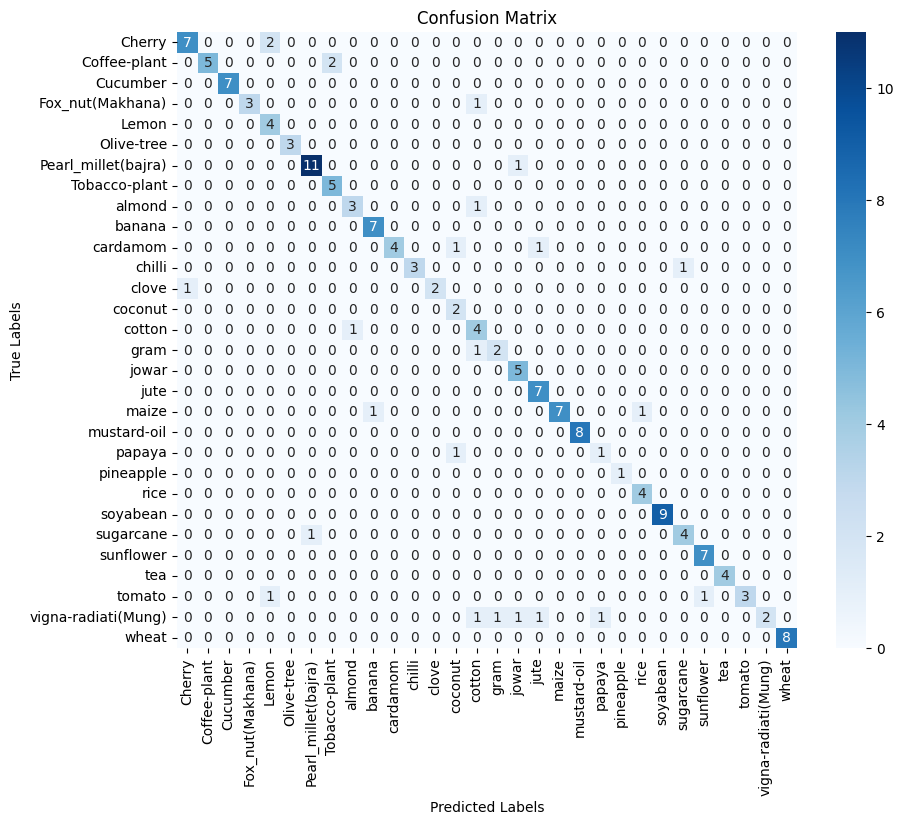

Overall Accuracy: 85.54%


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Модифицированная функция для тестирования модели с использованием дополнительных метрик
def test_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Генерация классификационного отчета
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Построение матрицы неточностей
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Вычисление общей точности
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Вызов функции тестирования с метриками
test_model_with_metrics(model, test_loader, class_names=label_encoder.classes_)
